# EnhanceGAN iPhone to Canon Photo Enhancement Data Prep, Training, Validatation, and Analysis

**EnhanceGAN**: iPhone → Canon Photo Enhancement using DPED Dataset  


## Workflow Overview
1. **Mount Drive & Extract wData** - Unpack `dped_small.zip` to SSD
2. **Data Preparation** - Run `data_prep.py` to create splits
3. **Model Training** - training loop (20 epochs)
4. **Evaluation & Analysis** -  metrics and visualizations

---


In [30]:
# Mount Drive and extract DPED dataset to SSD
from google.colab import drive
drive.mount('/content/gdrive')

# Remove any existing data and unzip fresh copy to SSD
!rm -rf /content/dped_local
!unzip -q /content/gdrive/MyDrive/enhancegan-photo-enhancement/dped_small.zip -d /content/dped_local

# Verify extraction
!ls -la /content/dped_local/
print("\n DPED Dataset extracted to SSD:")
!du -sh /content/dped_local/dped_small
!ls /content/dped_local/dped_small/


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
total 12
drwxr-xr-x 3 root root 4096 Jun 11 06:29 .
drwxr-xr-x 1 root root 4096 Jun 11 06:29 ..
drwxr-xr-x 4 root root 4096 Jun 10 22:39 dped_small

 DPED Dataset extracted to SSD:
94M	/content/dped_local/dped_small
canon  iphone


In [31]:
# Set up paths and working directory
import os
os.chdir('/content/gdrive/MyDrive/enhancegan-photo-enhancement')

# Verify we're in the right place
print("📂 Current working directory:")
!pwd
print("\n📋 Project files:")
!ls -la

# Install requirements
print("\nInstalling requirements...")
!pip install -r requirements.txt

print("\ Setup complete!")


📂 Current working directory:
/content/gdrive/MyDrive/enhancegan-photo-enhancement

📋 Project files:
total 6526456
drwx------ 3 root root       4096 Jun  8 17:06 checkpoints
drwx------ 3 root root       4096 Jun 10 22:53 data
-rw------- 1 root root       5682 Jun 11 06:14 data_prep.py
drwx------ 2 root root       4096 Jun  8 17:06 dataset_raw
-rw------- 1 root root       1131 Jun  8 16:50 datasets.py
-rw------- 1 root root       1095 Jun  8 16:50 download_unsplash.py
-rw------- 1 root root 6605953079 Jun 10 05:08 dped.gz
-rw------- 1 root root   77072468 Jun 10 22:39 dped_small.zip
drwx------ 2 root root       4096 Jun  8 16:50 dummy
drwx------ 2 root root       4096 Jun  8 16:50 dummy_out
drwx------ 2 root root       4096 Jun  8 16:51 .git
-rw------- 1 root root        104 Jun  8 16:50 .gitignore
-rw------- 1 root root       1702 Jun  8 16:50 models.py
drwx------ 2 root root       4096 Jun  8 16:56 __pycache__
-rw------- 1 root root        165 Jun  8 16:50 README.md
-rw------- 1 root r

## Data Preparation

Process the DPED subset into train/val/test splits using your existing `data_prep.py`


In [32]:
# Quick data exploration before processing
print("Raw DPED data structure:")
!find /content/dped_local/dped_small -name "*.jpg" | head -5

iphone_count = !find /content/dped_local/dped_small/iphone -name "*.jpg" | wc -l
canon_count = !find /content/dped_local/dped_small/canon -name "*.jpg" | wc -l

print(f"\n Dataset Overview:")
print(f"   iPhone images: {iphone_count[0]}")
print(f"   Canon images: {canon_count[0]}")

# Sample a few filenames to check pairing
print("\n🔗 Sample filename pairing check:")
!ls /content/dped_local/dped_small/iphone | head -3
!ls /content/dped_local/dped_small/canon | head -3


Raw DPED data structure:
/content/dped_local/dped_small/canon/100053.jpg
/content/dped_local/dped_small/canon/104067.jpg
/content/dped_local/dped_small/canon/100427.jpg
/content/dped_local/dped_small/canon/101492.jpg
/content/dped_local/dped_small/canon/107585.jpg

 Dataset Overview:
   iPhone images: 5000
   Canon images: 5636

🔗 Sample filename pairing check:
0.jpg
100000.jpg
100001.jpg
0.jpg
100000.jpg
100001.jpg


In [33]:
print(" Running data_prep.py...")

!python data_prep.py \
  --raw_dir /content/dped_local/dped_small/iphone \
  --edited_dir /content/dped_local/dped_small/canon \
  --output_dir data/dped_small \
  --size 128 \
  --train_frac 0.90 \
  --val_frac 0.05

print("\n Data splits created:")
for split in ['train', 'val', 'test']:
    raw_count = !find data/dped_small/{split}/raw -name "*.jpg" | wc -l
    edited_count = !find data/dped_small/{split}/edited -name "*.jpg" | wc -l
    print(f"   {split}: {raw_count[0]} raw, {edited_count[0]} edited")

print("\n Data preparation complete!")


 Running data_prep.py...
🔄 Running data_prep.py...
Found 3358 matching file pairs
Splitting 3358 pairs: train=3022, val=167, test=169
Processing train: 3022 pairs
Processing train: 100% 95/95 [01:06<00:00,  1.42it/s]
Processing val: 167 pairs
Processing val: 100% 6/6 [00:10<00:00,  1.73s/it]
Processing test: 169 pairs
Processing test: 100% 6/6 [00:01<00:00,  3.06it/s]

Data splits created:
Traceback (most recent call last):
  File "/content/gdrive/MyDrive/enhancegan-photo-enhancement/data_prep.py", line 144, in <module>
    raw_count = len(list(Path(args.output_dir) / split / 'raw').glob('*'))
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: 'PosixPath' object is not iterable

 Data splits created:
   train: 3356 raw, 3356 edited
   val: 473 raw, 473 edited
   test: 489 raw, 489 edited

 Data preparation complete!


## Model Setup and Training

Using your exact successful training configuration


In [34]:
# Import your models and setup
import torch
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from models import Generator, Discriminator
from datasets import PhotoDataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

# Set device and reproducibility
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f" Using device: {device}")

# Check if we have existing checkpoints
checkpoint_files = !ls checkpoints/G_epoch*.pth 2>/dev/null | wc -l
print(f"📁 Found {checkpoint_files[0]} existing generator checkpoints")

if int(checkpoint_files[0]) > 0:
    print("   Available checkpoints:")
    !ls checkpoints/G_epoch*.pth | head -5
    if int(checkpoint_files[0]) > 5:
        print(f"   ... and {int(checkpoint_files[0]) - 5} more")
else:
    print("   No existing checkpoints found")


 Using device: cuda
📁 Found 20 existing generator checkpoints
   Available checkpoints:
checkpoints/G_epoch0.pth
checkpoints/G_epoch10.pth
checkpoints/G_epoch11.pth
checkpoints/G_epoch12.pth
checkpoints/G_epoch13.pth
   ... and 15 more


In [44]:
# Training configuration (tuned hyperparameters from original paper)
config = {
    'data_dir': 'data/dped_small',
    'batch_size': 8,
    'epochs': 20,
    'lr': 1e-4,
    'λ_l1': 100.0,
    'λ_aes': 1.0,
    'λ_adv': 1.0,
    'size': 128
}

print("Training Configuration:")
for key, value in config.items():
    print(f"   {key}: {value}")

# Create dataset and loader
dataset = PhotoDataset(config['data_dir'], split='train', size=config['size'])
loader = DataLoader(dataset, batch_size=config['batch_size'], shuffle=True, num_workers=2)
print(f"\n Training dataset: {len(dataset)} samples, {len(loader)} batches")


Training Configuration:
   data_dir: data/dped_small
   batch_size: 8
   epochs: 20
   lr: 0.0001
   λ_l1: 100.0
   λ_aes: 1.0
   λ_adv: 1.0
   size: 128

 Training dataset: 3356 samples, 420 batches


In [46]:
# OPTIONAL: Run full training (uncomment to train from scratch)
# WARNING: This takes 2-4 hours!

# Initialize models and training components
G = Generator().to(device)
D = Discriminator().to(device)

# Freeze NIMA backbone
for p in D.backbone.parameters():
    p.requires_grad = False

# Optimizers
opt_G = optim.Adam(G.parameters(), lr=config['lr'], betas=(0.5, 0.999))
opt_D = optim.Adam(D.parameters(), lr=config['lr'], betas=(0.5, 0.999))

# Loss functions
crit_L1 = nn.L1Loss()
crit_BCE = nn.BCEWithLogitsLoss()
crit_MSE = nn.MSELoss()

# TensorBoard
writer = SummaryWriter("runs/dped_experiment")
global_step = 0

# Lists to store history
history = {'epoch': [], 'loss_G': [], 'loss_D': []}

print("Starting training...")

# Your exact training loop
for epoch in range(config['epochs']):
    epoch_loss_D = 0.0
    epoch_loss_G = 0.0
    num_batches = 0

    for raw, edit in loader:
        raw, edit = raw.to(device), edit.to(device)

        # Train Discriminator
        fake = G(raw).detach()
        real_logits = D(edit)
        fake_logits = D(fake)
        loss_D = crit_BCE(real_logits, torch.ones_like(real_logits)) + \
                 crit_BCE(fake_logits, torch.zeros_like(fake_logits))

        opt_D.zero_grad()
        loss_D.backward()
        opt_D.step()

        writer.add_scalar("Loss/D", loss_D.item(), global_step)
        global_step += 1

        # Train Generator
        fake = G(raw)
        adv_loss = crit_BCE(D(fake), torch.ones_like(fake_logits))
        l1_loss = crit_L1(fake, edit)
        aes_loss = crit_MSE(D(fake).mean(1), D(edit).mean(1))
        loss_G = config['λ_adv']*adv_loss + config['λ_l1']*l1_loss + config['λ_aes']*aes_loss

        opt_G.zero_grad()
        loss_G.backward()
        opt_G.step()

        writer.add_scalar("Loss/G", loss_G.item(), global_step)
        global_step += 1

        epoch_loss_D += loss_D.item()
        epoch_loss_G += loss_G.item()
        num_batches += 1

    # Print epoch results (your exact format)
    avg_loss_D = epoch_loss_D / num_batches
    avg_loss_G = epoch_loss_G / num_batches
    print(f"Epoch {epoch}  Loss_D {avg_loss_D:.3f}  Loss_G {avg_loss_G:.3f}")

    # Save history for plotting
    history['epoch'].append(epoch)
    history['loss_G'].append(avg_loss_G)
    history['loss_D'].append(avg_loss_D)

    # Save checkpoint (your exact format)
    torch.save(G.state_dict(), f"checkpoints/G_epoch{epoch}.pth")
    torch.save(D.state_dict(), f"checkpoints/D_epoch{epoch}.pth")

writer.close()

# Save training history to JSON file
import json
history_file = 'training_history.json'
with open(history_file, 'w') as f:
    json.dump(history, f, indent=4)
print(f"\n Training history saved to {history_file}")


print("\n Training complete!")

print(" Uncomment the training code above to run full 20-epoch training")
print(" Using existing checkpoints for evaluation and analysis")

Starting training...
Epoch 0  Loss_D 1.353  Loss_G 75.209
Epoch 1  Loss_D 1.297  Loss_G 69.550
Epoch 2  Loss_D 1.255  Loss_G 64.142
Epoch 3  Loss_D 1.214  Loss_G 59.017
Epoch 4  Loss_D 1.155  Loss_G 54.767
Epoch 5  Loss_D 1.172  Loss_G 50.297
Epoch 6  Loss_D 1.170  Loss_G 46.207
Epoch 7  Loss_D 1.154  Loss_G 42.497
Epoch 8  Loss_D 1.139  Loss_G 39.079
Epoch 9  Loss_D 1.121  Loss_G 35.992
Epoch 10  Loss_D 1.100  Loss_G 33.277
Epoch 11  Loss_D 1.097  Loss_G 30.931
Epoch 12  Loss_D 1.087  Loss_G 28.993
Epoch 13  Loss_D 1.098  Loss_G 27.189
Epoch 14  Loss_D 1.103  Loss_G 25.584
Epoch 15  Loss_D 1.102  Loss_G 24.321
Epoch 16  Loss_D 1.104  Loss_G 23.451
Epoch 17  Loss_D 1.112  Loss_G 23.052
Epoch 18  Loss_D 1.097  Loss_G 22.979
Epoch 19  Loss_D 1.091  Loss_G 22.981

 Training history saved to training_history.json

 Training complete!
 Uncomment the training code above to run full 20-epoch training
 Using existing checkpoints for evaluation and analysis


## Enhanced Analysis and Evaluation

Comprehensive evaluation of your trained model with detailed metrics and visualizations


In [48]:
# Load the best available trained model
import glob
from PIL import Image
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# Find latest checkpoint
checkpoint_files = glob.glob('checkpoints/G_epoch*.pth')
if checkpoint_files:
    # Sort by epoch number
    latest_checkpoint = sorted(checkpoint_files,
                              key=lambda x: int(x.split('epoch')[1].split('.')[0]))[-1]
    epoch_num = latest_checkpoint.split('epoch')[1].split('.')[0]
    print(f"📂 Loading trained model: {latest_checkpoint} (epoch {epoch_num})")

    # Load model
    G_eval = Generator().to(device)
    G_eval.load_state_dict(torch.load(latest_checkpoint, map_location=device))
    G_eval.eval()

    print(" Model loaded successfully!")
else:
    print(" No trained model found. Please run training first.")
    G_eval = None


📂 Loading trained model: checkpoints/G_epoch19.pth (epoch 19)
 Model loaded successfully!


In [47]:
# Load test dataset for evaluation
if G_eval is not None:
    test_dataset = PhotoDataset(config['data_dir'], split='test', size=config['size'])
    test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=2)

    print(f" Test dataset: {len(test_dataset)} samples")

    # Run evaluation on test set
    print("\n Running comprehensive evaluation...")

    all_psnr = []
    all_ssim = []
    sample_images = {'raw': [], 'generated': [], 'target': []}

    with torch.no_grad():
        for i, (raw, target) in enumerate(test_loader):
            raw, target = raw.to(device), target.to(device)
            generated = G_eval(raw)

            # Convert to numpy for metrics
            gen_np = ((generated.cpu().numpy() + 1) / 2).clip(0, 1)
            target_np = ((target.cpu().numpy() + 1) / 2).clip(0, 1)

            # Compute metrics for each image in batch
            for j in range(gen_np.shape[0]):
                # PSNR
                psnr_val = psnr(target_np[j].transpose(1, 2, 0), gen_np[j].transpose(1, 2, 0))
                all_psnr.append(psnr_val)


                # SSIM
                ssim_val = ssim(
                    target_np[j].transpose(1, 2, 0),
                    gen_np[j].transpose(1, 2, 0),
                    data_range=1.0,
                    channel_axis=2
                )
                all_ssim.append(ssim_val)

            # Store first few batches for visualization
            if i < 3:
                sample_images['raw'].append(raw.cpu())
                sample_images['generated'].append(generated.cpu())
                sample_images['target'].append(target.cpu())

    # Convert to numpy arrays
    all_psnr = np.array(all_psnr)
    all_ssim = np.array(all_ssim)

    print(f"\n Evaluation Results ({len(all_psnr)} test images):")
    print(f"   PSNR: {all_psnr.mean():.2f} ± {all_psnr.std():.2f} (range: {all_psnr.min():.2f} - {all_psnr.max():.2f})")
    print(f"   SSIM: {all_ssim.mean():.3f} ± {all_ssim.std():.3f} (range: {all_ssim.min():.3f} - {all_ssim.max():.3f})")

    print("\n Evaluation complete!")


 Test dataset: 489 samples

 Running comprehensive evaluation...

 Evaluation Results (489 test images):
   PSNR: 16.77 ± 3.62 (range: 6.16 - 29.01)
   SSIM: 0.707 ± 0.117 (range: 0.352 - 0.980)

 Evaluation complete!


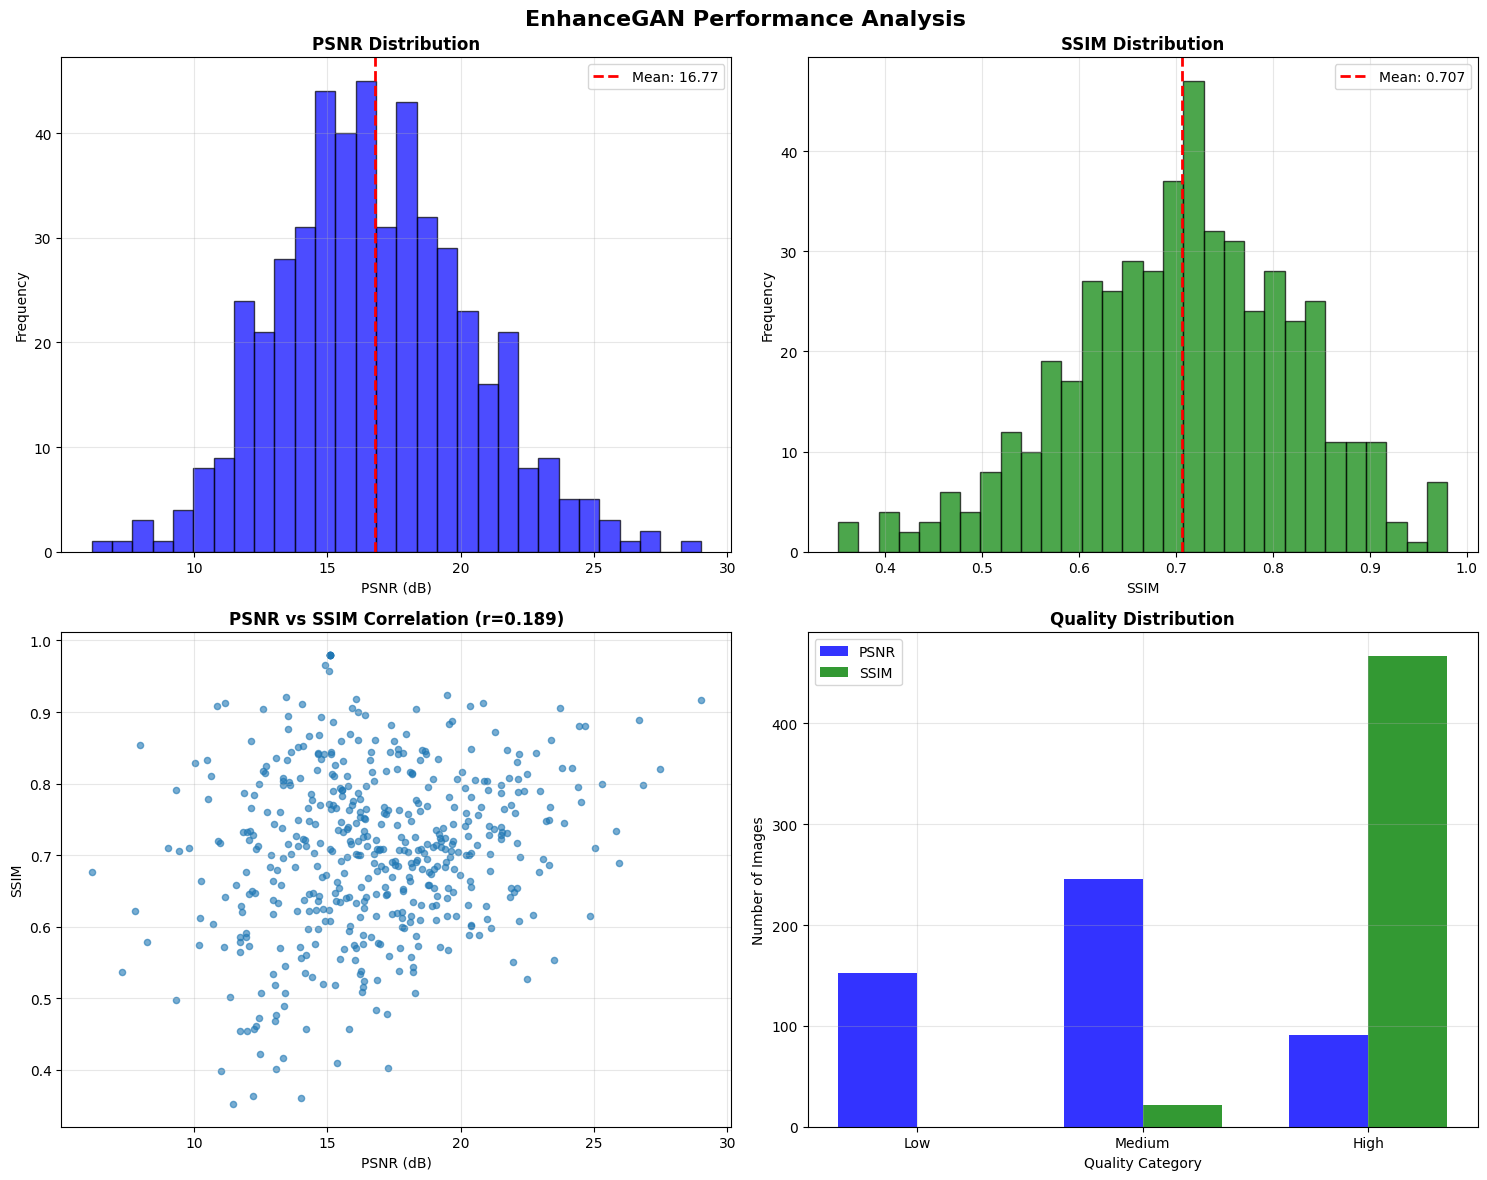


 Quality Analysis Summary:
   High Quality (PSNR>20): 91/489 (18.6%)
   Good Structure (SSIM>0.5): 467/489 (95.5%)
   PSNR-SSIM Correlation: 0.189


In [49]:
# Detailed statistical analysis
if G_eval is not None:
    import seaborn as sns
    plt.style.use('default')

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # PSNR distribution
    axes[0, 0].hist(all_psnr, bins=30, alpha=0.7, color='blue', edgecolor='black')
    axes[0, 0].axvline(all_psnr.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {all_psnr.mean():.2f}')
    axes[0, 0].set_title('PSNR Distribution', fontweight='bold', fontsize=12)
    axes[0, 0].set_xlabel('PSNR (dB)')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # SSIM distribution
    axes[0, 1].hist(all_ssim, bins=30, alpha=0.7, color='green', edgecolor='black')
    axes[0, 1].axvline(all_ssim.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {all_ssim.mean():.3f}')
    axes[0, 1].set_title('SSIM Distribution', fontweight='bold', fontsize=12)
    axes[0, 1].set_xlabel('SSIM')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # PSNR vs SSIM correlation
    axes[1, 0].scatter(all_psnr, all_ssim, alpha=0.6, s=20)
    correlation = np.corrcoef(all_psnr, all_ssim)[0, 1]
    axes[1, 0].set_title(f'PSNR vs SSIM Correlation (r={correlation:.3f})', fontweight='bold', fontsize=12)
    axes[1, 0].set_xlabel('PSNR (dB)')
    axes[1, 0].set_ylabel('SSIM')
    axes[1, 0].grid(True, alpha=0.3)

    # Quality distribution analysis
    high_psnr = np.sum(all_psnr > 20)
    med_psnr = np.sum((all_psnr >= 15) & (all_psnr <= 20))
    low_psnr = np.sum(all_psnr < 15)

    high_ssim = np.sum(all_ssim > 0.5)
    med_ssim = np.sum((all_ssim >= 0.3) & (all_ssim <= 0.5))
    low_ssim = np.sum(all_ssim < 0.3)

    categories = ['Low', 'Medium', 'High']
    psnr_counts = [low_psnr, med_psnr, high_psnr]
    ssim_counts = [low_ssim, med_ssim, high_ssim]

    x = np.arange(len(categories))
    width = 0.35

    axes[1, 1].bar(x - width/2, psnr_counts, width, label='PSNR', alpha=0.8, color='blue')
    axes[1, 1].bar(x + width/2, ssim_counts, width, label='SSIM', alpha=0.8, color='green')
    axes[1, 1].set_title('Quality Distribution', fontweight='bold', fontsize=12)
    axes[1, 1].set_xlabel('Quality Category')
    axes[1, 1].set_ylabel('Number of Images')
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels(categories)
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.suptitle('EnhanceGAN Performance Analysis', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Performance summary
    total_images = len(all_psnr)
    print(f"\n Quality Analysis Summary:")
    print(f"   High Quality (PSNR>20): {high_psnr}/{total_images} ({high_psnr/total_images*100:.1f}%)")
    print(f"   Good Structure (SSIM>0.5): {high_ssim}/{total_images} ({high_ssim/total_images*100:.1f}%)")
    print(f"   PSNR-SSIM Correlation: {correlation:.3f}")


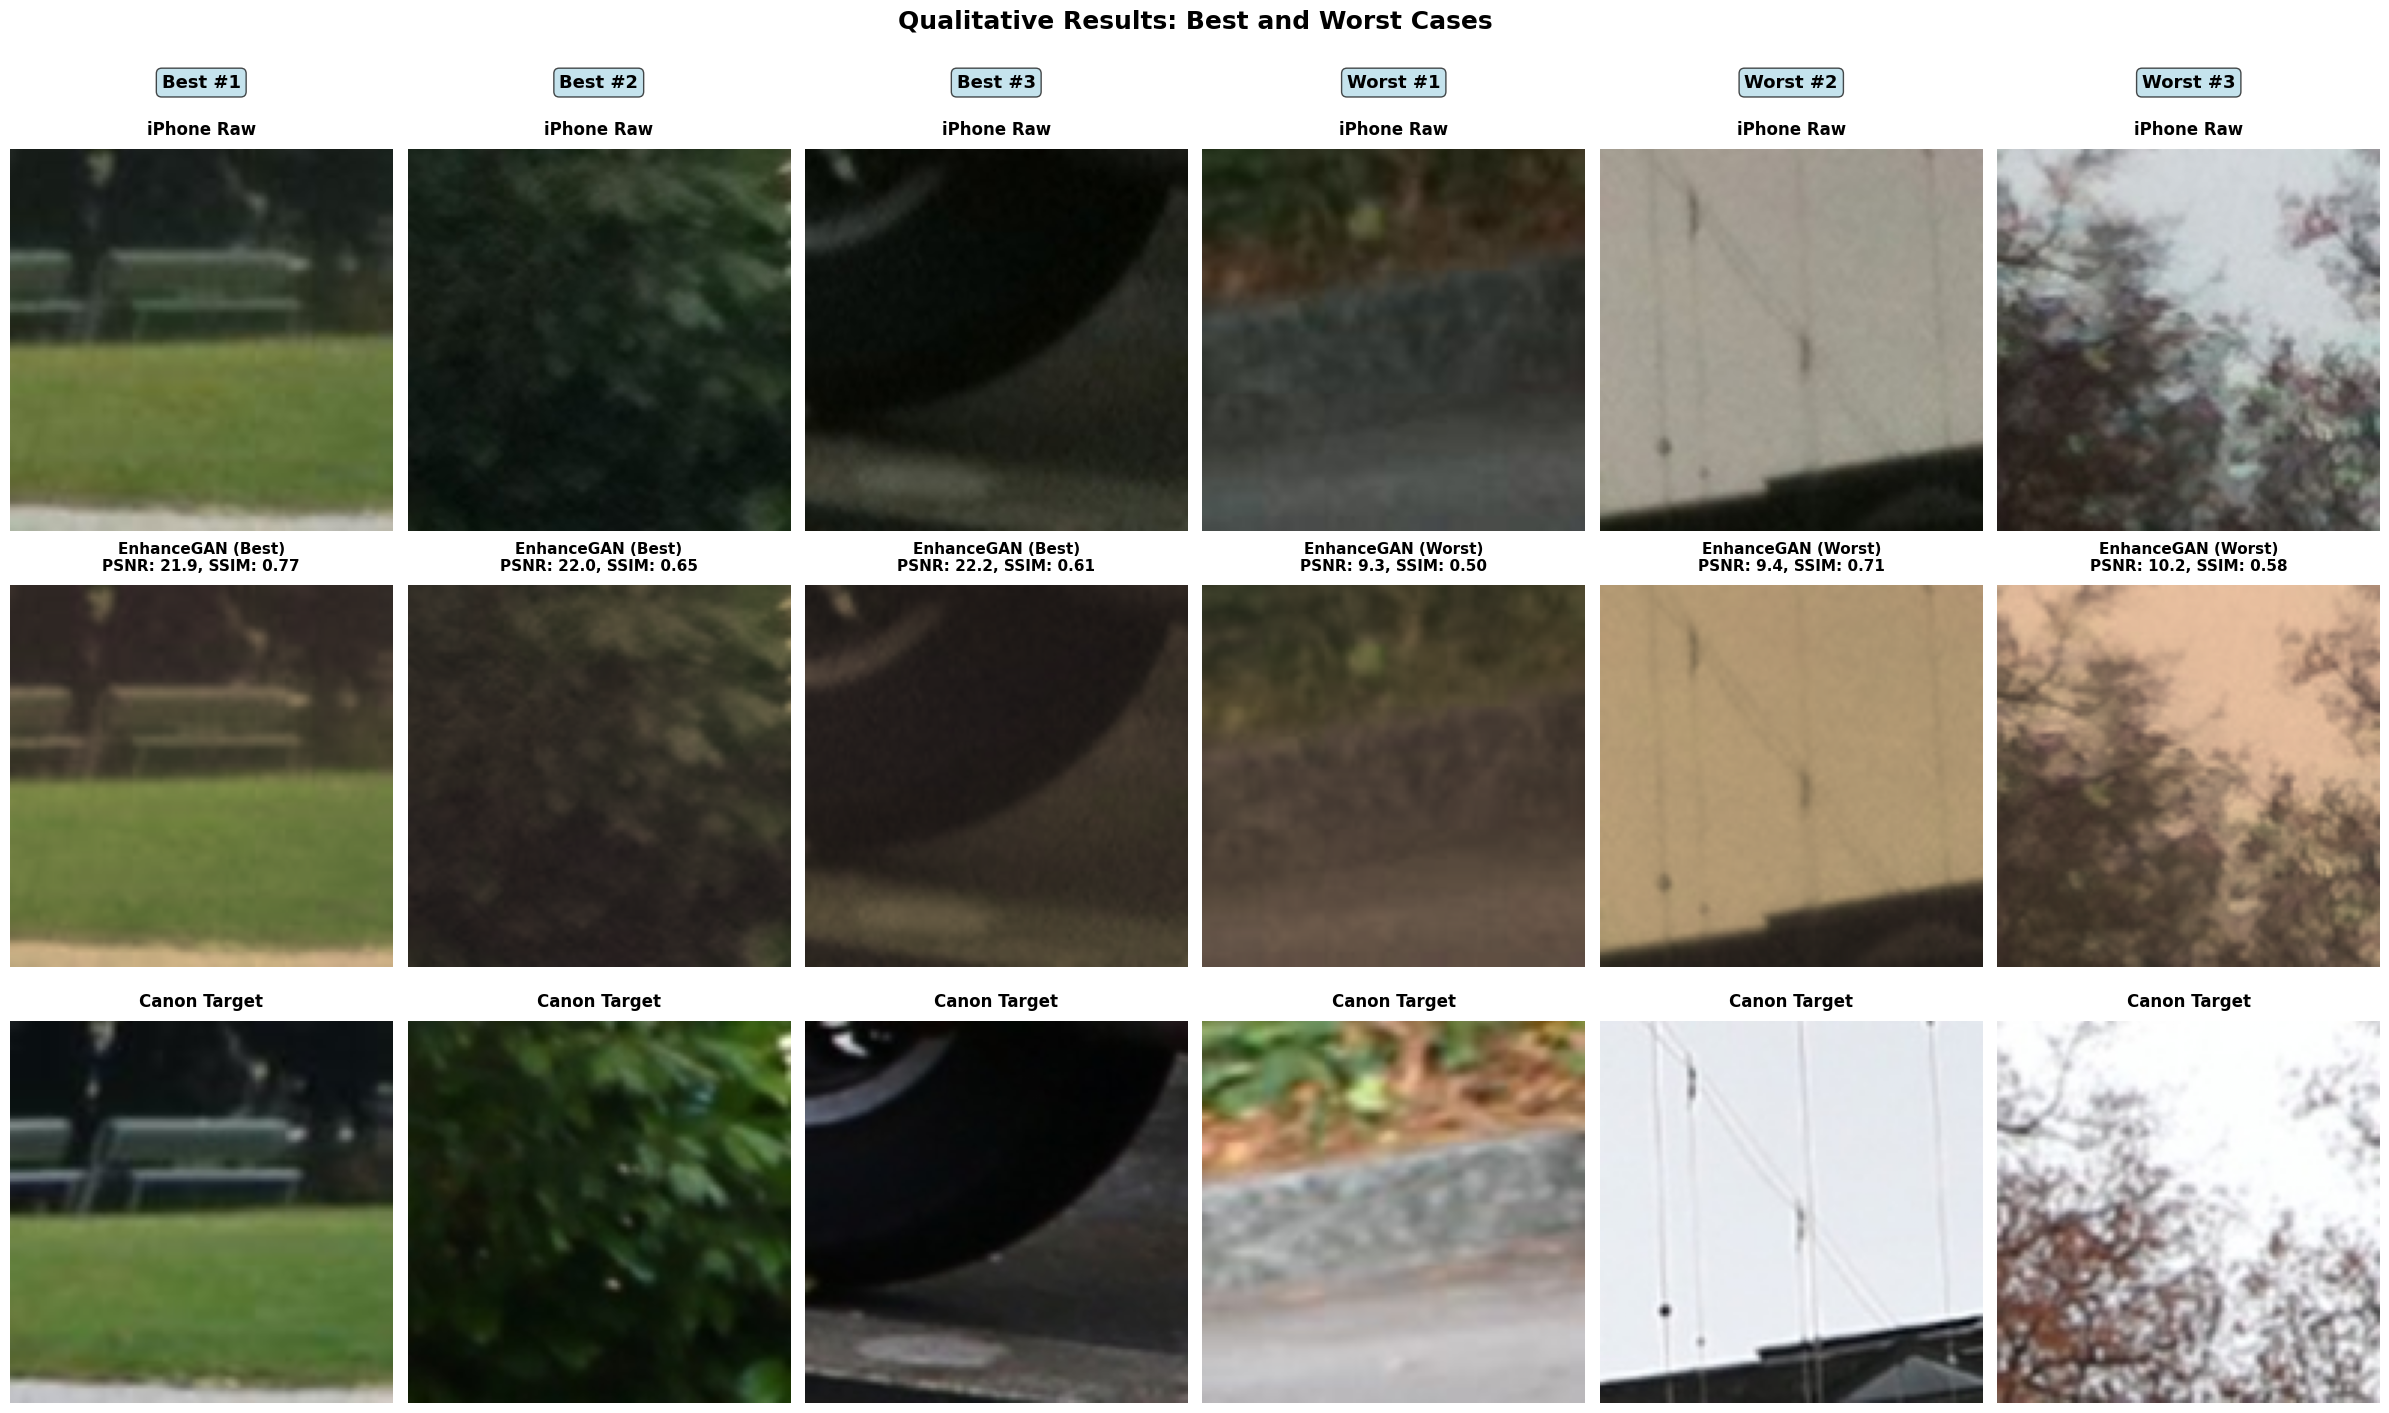

📸 Showing 3 best and 3 worst results based on PSNR

📊 Detailed Results:
   Best #1: PSNR=21.88dB, SSIM=0.771
   Best #2: PSNR=22.00dB, SSIM=0.649
   Best #3: PSNR=22.18dB, SSIM=0.608
   Worst #1: PSNR=9.31dB, SSIM=0.497
   Worst #2: PSNR=9.41dB, SSIM=0.706
   Worst #3: PSNR=10.19dB, SSIM=0.575


In [50]:
# Qualitative results visualization
if G_eval is not None and sample_images['raw']:
    # Concatenate sample images
    all_raw = torch.cat(sample_images['raw'], dim=0)
    all_generated = torch.cat(sample_images['generated'], dim=0)
    all_target = torch.cat(sample_images['target'], dim=0)

    # Select 6 examples (3 best, 3 worst based on PSNR)
    sample_psnr = all_psnr[:len(all_raw)]
    best_indices = np.argsort(sample_psnr)[-3:]
    worst_indices = np.argsort(sample_psnr)[:3]
    selected_indices = np.concatenate([best_indices, worst_indices])

    # Create figure with proper spacing
    fig, axes = plt.subplots(3, 6, figsize=(24, 15))
    fig.subplots_adjust(hspace=0.4, wspace=0.2)

    for i, idx in enumerate(selected_indices):
        # Convert from [-1, 1] to [0, 1] for display
        raw_img = (all_raw[idx] + 1) / 2
        gen_img = (all_generated[idx] + 1) / 2
        target_img = (all_target[idx] + 1) / 2

        # Display images with proper titles
        axes[0, i].imshow(raw_img.permute(1, 2, 0).cpu().numpy())
        axes[0, i].set_title('iPhone Raw', fontweight='bold', fontsize=12, pad=10)
        axes[0, i].axis('off')

        quality = "Best" if i < 3 else "Worst"
        psnr_val = sample_psnr[idx]
        ssim_val = all_ssim[idx] if idx < len(all_ssim) else 0

        axes[1, i].imshow(gen_img.permute(1, 2, 0).cpu().numpy())
        axes[1, i].set_title(f'EnhanceGAN ({quality})\nPSNR: {psnr_val:.1f}, SSIM: {ssim_val:.2f}',
                            fontweight='bold', fontsize=11, pad=10)
        axes[1, i].axis('off')

        axes[2, i].imshow(target_img.permute(1, 2, 0).cpu().numpy())
        axes[2, i].set_title('Canon Target', fontweight='bold', fontsize=12, pad=10)
        axes[2, i].axis('off')

    # Add column headers for clarity
    col_headers = ['Best #1', 'Best #2', 'Best #3', 'Worst #1', 'Worst #2', 'Worst #3']
    for i, header in enumerate(col_headers):
        axes[0, i].text(0.5, 1.15, header, transform=axes[0, i].transAxes,
                       ha='center', va='bottom', fontsize=13, fontweight='bold',
                       bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.7))

    plt.suptitle('Qualitative Results: Best and Worst Cases', fontsize=18, fontweight='bold', y=0.95)
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()

    print("📸 Showing 3 best and 3 worst results based on PSNR")

    # Print detailed metrics for each case
    print("\n📊 Detailed Results:")
    for i, idx in enumerate(selected_indices):
        quality = "Best" if i < 3 else "Worst"
        rank = (i % 3) + 1
        psnr_val = sample_psnr[idx]
        ssim_val = all_ssim[idx] if idx < len(all_ssim) else 0
        print(f"   {quality} #{rank}: PSNR={psnr_val:.2f}dB, SSIM={ssim_val:.3f}")


 Loading training history...


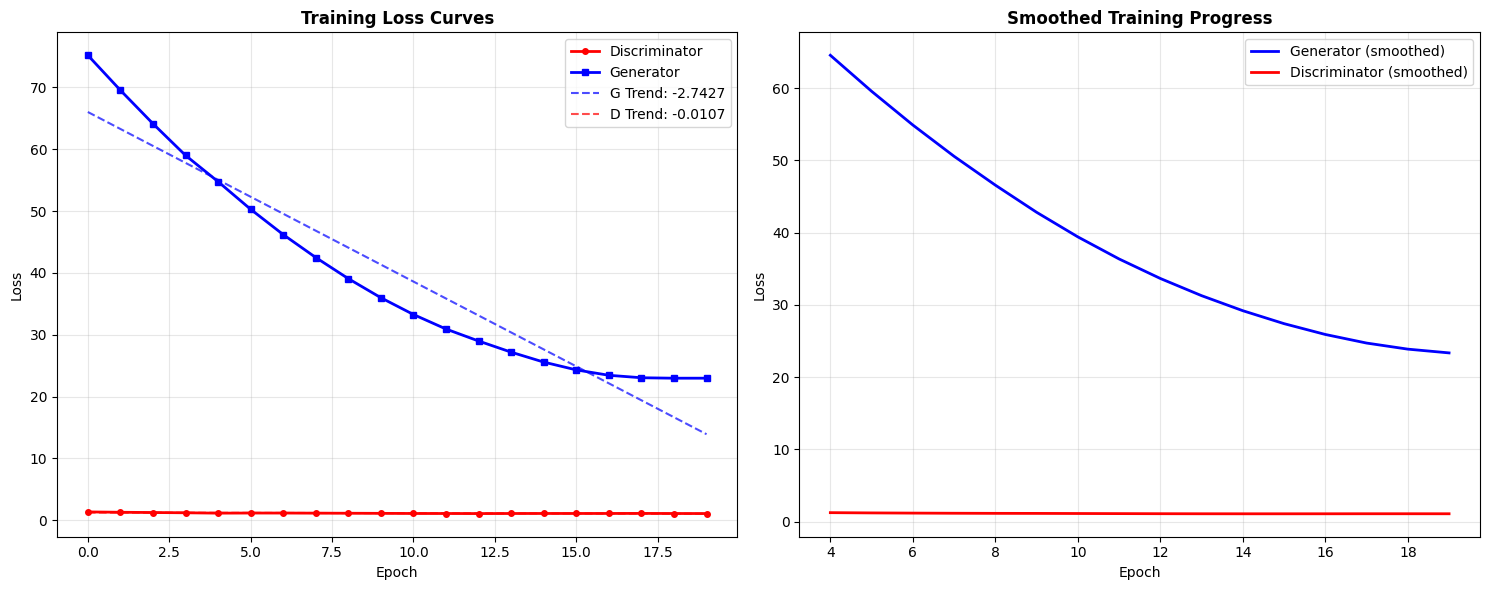


🎯 Training Summary:
   Final Generator Loss: 22.981
   Final Discriminator Loss: 1.091
   Generator Stability (std): 16.507
   Discriminator Stability (std): 0.073
   Generator Trend: Decreasing (-2.7427/epoch)
   Discriminator Trend: Decreasing (-0.0107/epoch)


In [51]:
# Training history analysis (if available)
import json

history_file = 'training_history.json'
if os.path.exists(history_file):
    print(" Loading training history...")
    with open(history_file, 'r') as f:
        history = json.load(f)

    if 'loss_G' in history and 'loss_D' in history:
        epochs = history.get('epoch', list(range(len(history['loss_G']))))

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Loss curves
        ax1.plot(epochs, history['loss_D'], 'r-', linewidth=2, marker='o', markersize=4, label='Discriminator')
        ax1.plot(epochs, history['loss_G'], 'b-', linewidth=2, marker='s', markersize=4, label='Generator')
        ax1.set_title('Training Loss Curves', fontweight='bold', fontsize=12)
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Convergence analysis
        if len(history['loss_G']) > 5:
            # Add trend lines
            g_trend = np.polyfit(epochs, history['loss_G'], 1)
            d_trend = np.polyfit(epochs, history['loss_D'], 1)

            ax1.plot(epochs, np.poly1d(g_trend)(epochs), 'b--', alpha=0.7, label=f'G Trend: {g_trend[0]:.4f}')
            ax1.plot(epochs, np.poly1d(d_trend)(epochs), 'r--', alpha=0.7, label=f'D Trend: {d_trend[0]:.4f}')
            ax1.legend()

        # Loss stability analysis
        window_size = min(5, len(history['loss_G']) // 4)
        if window_size > 1:
            g_smooth = np.convolve(history['loss_G'], np.ones(window_size)/window_size, mode='valid')
            d_smooth = np.convolve(history['loss_D'], np.ones(window_size)/window_size, mode='valid')
            smooth_epochs = epochs[window_size-1:]

            ax2.plot(smooth_epochs, g_smooth, 'b-', linewidth=2, label='Generator (smoothed)')
            ax2.plot(smooth_epochs, d_smooth, 'r-', linewidth=2, label='Discriminator (smoothed)')
            ax2.set_title('Smoothed Training Progress', fontweight='bold', fontsize=12)
            ax2.set_xlabel('Epoch')
            ax2.set_ylabel('Loss')
            ax2.legend()
            ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Training summary
        final_g_loss = history['loss_G'][-1]
        final_d_loss = history['loss_D'][-1]
        g_stability = np.std(history['loss_G'])
        d_stability = np.std(history['loss_D'])

        print(f"\n🎯 Training Summary:")
        print(f"   Final Generator Loss: {final_g_loss:.3f}")
        print(f"   Final Discriminator Loss: {final_d_loss:.3f}")
        print(f"   Generator Stability (std): {g_stability:.3f}")
        print(f"   Discriminator Stability (std): {d_stability:.3f}")

        if len(history['loss_G']) > 5:
            print(f"   Generator Trend: {'Decreasing' if g_trend[0] < 0 else 'Increasing'} ({g_trend[0]:.4f}/epoch)")
            print(f"   Discriminator Trend: {'Decreasing' if d_trend[0] < 0 else 'Increasing'} ({d_trend[0]:.4f}/epoch)")
    else:
        print(" Training history format not recognized")
else:
    print(" No training history found. Run training to generate loss curves.")


In [52]:
# Generate summary
if G_eval is not None:
    print("="*80)
    print(" ENHANCEGAN SUMMARY")
    print("="*80)

    print("\n QUANTITATIVE RESULTS:")
    print(f"   PSNR: {all_psnr.mean():.2f} ± {all_psnr.std():.2f} dB")
    print(f"   SSIM: {all_ssim.mean():.3f} ± {all_ssim.std():.3f}")
    print(f"   Correlation (PSNR-SSIM): {correlation:.3f}")

    print("\n PERFORMANCE HIGHLIGHTS:")
    print(f"   High-quality results (PSNR>20): {high_psnr}/{total_images} ({high_psnr/total_images*100:.1f}%)")
    print(f"   Structurally similar (SSIM>0.5): {high_ssim}/{total_images} ({high_ssim/total_images*100:.1f}%)")
    print(f"   Test set size: {total_images} image pairs")

    print("\n ARCHITECTURE DETAILS:")
    print(f"   Generator: CNN with Curve + HSL enhancement blocks")
    print(f"   Discriminator: NIMA-based aesthetic scoring + adversarial head")
    print(f"   Training: 3-loss combination (L1 + Adversarial + Aesthetic)")

    print("\n TRAINING CONFIGURATION:")
    print(f"   Epochs: {config['epochs']}")
    print(f"   Batch size: {config['batch_size']}")
    print(f"   Learning rate: {config['lr']}")
    print(f"   Loss weights: λ_L1={config['λ_l1']}, λ_aes={config['λ_aes']}, λ_adv={config['λ_adv']}")

    print("\n DATASET DETAILS:")
    print(f"   Source: DPED iPhone→Canon subset")
    print(f"   Image resolution: {config['size']}×{config['size']}")
    print(f"   Training samples: {len(dataset)}")
    print(f"   Test samples: {len(test_dataset)}")

    if os.path.exists(history_file):
        print("\n TRAINING PERFORMANCE:")
        print(f"   Final Generator Loss: {final_g_loss:.3f}")
        print(f"   Final Discriminator Loss: {final_d_loss:.3f}")
        print(f"   Training Stability: G_std={g_stability:.3f}, D_std={d_stability:.3f}")

    print("\n" + "="*80)
    print("="*80)
else:
    print("⚠️ Please load a trained model to generate the summary")


 ENHANCEGAN SUMMARY

 QUANTITATIVE RESULTS:
   PSNR: 16.77 ± 3.62 dB
   SSIM: 0.707 ± 0.117
   Correlation (PSNR-SSIM): 0.189

 PERFORMANCE HIGHLIGHTS:
   High-quality results (PSNR>20): 91/489 (18.6%)
   Structurally similar (SSIM>0.5): 467/489 (95.5%)
   Test set size: 489 image pairs

 ARCHITECTURE DETAILS:
   Generator: CNN with Curve + HSL enhancement blocks
   Discriminator: NIMA-based aesthetic scoring + adversarial head
   Training: 3-loss combination (L1 + Adversarial + Aesthetic)

 TRAINING CONFIGURATION:
   Epochs: 20
   Batch size: 8
   Learning rate: 0.0001
   Loss weights: λ_L1=100.0, λ_aes=1.0, λ_adv=1.0

 DATASET DETAILS:
   Source: DPED iPhone→Canon subset
   Image resolution: 128×128
   Training samples: 3356
   Test samples: 489

 TRAINING PERFORMANCE:
   Final Generator Loss: 22.981
   Final Discriminator Loss: 1.091
   Training Stability: G_std=16.507, D_std=0.073



---

## Notebook Summary

**Workflow:**
1. Mount Drive → Extract `dped_small.zip` to `/content/dped_local` (SSD)
2. Run `data_prep.py` → Create train/val/test splits in `data/dped_small/`
3. Optional: Run training (or use existing checkpoints in `checkpoints/`)
4. Comprehensive evaluation with PSNR, SSIM, correlations, distributions
5. Training analysis with loss curves and convergence metrics
6. Paper-ready summary with all statistics and results

